In [104]:
import numpy as np
import matplotlib.pyplot as plt
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
import compute_S_rate
import auxiliary_functions
import seaborn
import math

import networkx as nx
import random as rd

## Generation of congifuaration model with power-law distributed degrees

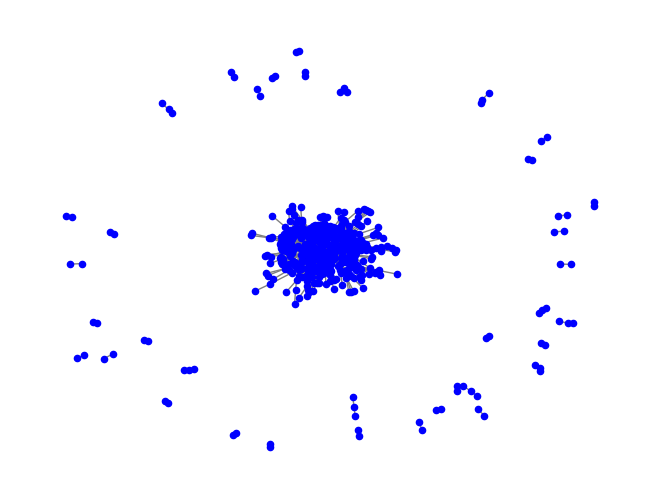

In [55]:
# Step 1: Generate power-law distributed degree sequence
N = 500  # Number of nodes
gamma = 2.1  # Power law exponent

# Using a minimum degree of 1 and generating the degree sequence
degree_sequence = np.random.zipf(gamma, N)

# Step 2: Ensure the degree sequence sum is even
if sum(degree_sequence) % 2 != 0:
    # If the sum is odd, make the first degree odd/even to correct it
    degree_sequence[0] += 1

# Step 3: Create the configuration model
G = nx.configuration_model(degree_sequence)

# Step 4: Remove parallel edges and self-loops (optional)
G = nx.Graph(G)  # This removes parallel edges
G.remove_edges_from(nx.selfloop_edges(G))  # Remove self-loops

# Step 5: Plot the graph (optional)
nx.draw(G, node_size=20, node_color="blue", edge_color="gray", with_labels=False)
plt.show()


In [56]:
nodes_lcc = max(nx.connected_components(G), key=len)
lcc = G.subgraph(nodes_lcc)
lcc_adj = nx.adjacency_matrix(lcc)

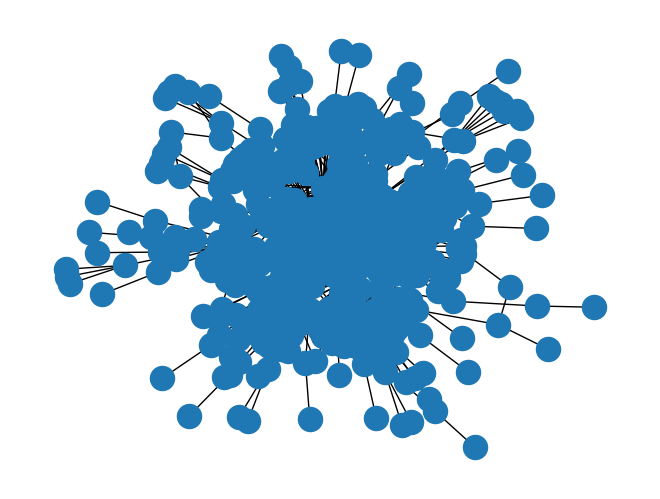

In [57]:
nx.draw(lcc)
plt.show()

In [58]:
mean_degree_lcc = np.mean(list(dict(nx.degree(lcc)).values()))
lcc_size = len(lcc.nodes())

p0 = 1/lcc_size*np.ones(lcc_size)

n_edges = lcc_adj.toarray().sum() / 2
degrees = lcc_adj.toarray().sum(0)
pi_0 = degrees / (2*n_edges)

In [59]:
times = [1, 2, 3, 5, 8, 10, 15, 20, 25, 35]

In [60]:
lamdas = [0.01, 0.1, 0.5, 1]

lcc_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(lcc_adj))
lcc_rw.compute_laplacian_matrices(random_walk = True)

for lamda in lamdas:
    lcc_rw.compute_inter_transition_matrices(lamda, dense_expm=False, use_sparse_stoch=False)
    lcc_rw.compute_transition_matrices(lamda)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


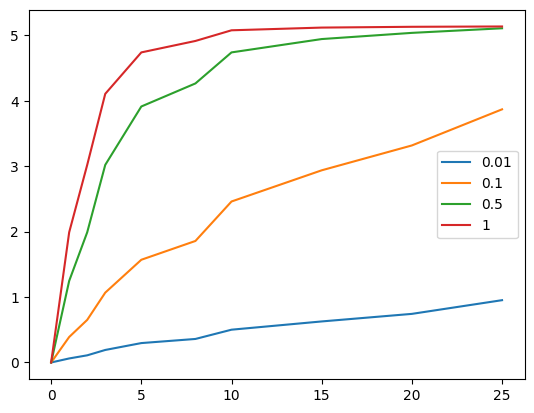

In [91]:
for lamda in lamdas:
    H_lcc_rw = compute_S_rate.compute_conditional_entropy(net=lcc_rw, list_T=lcc_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p0)
    plt.plot([0] + times[:-1], H_lcc_rw[list(H_lcc_rw.keys())[0]], label = str(lamda))

plt.legend()
plt.show()

### Comparable ER-graph

In [72]:
er = nx.erdos_renyi_graph(N, np.mean(degree_sequence) / (N-1))

nodes_er_lcc = max(nx.connected_components(er), key=len)
er_lcc = er.subgraph(nodes_er_lcc)
er_lcc_adj = nx.adjacency_matrix(er_lcc)

In [108]:
def sample_connected_subgraph(G, m):
    """
    Sample a connected subgraph with m nodes from graph G.
    """
    # Step 1: Repeat until a connected subgraph is found
    while True:
        # Sample m nodes randomly
        sampled_nodes = rd.sample(list(G.nodes()), m)
        
        # Create a subgraph induced by these sampled nodes
        subgraph = G.subgraph(sampled_nodes)
        
        # Step 2: Check if the subgraph is connected
        if nx.is_connected(subgraph):
            return subgraph

In [117]:
er_lcc = sample_connected_subgraph(er_lcc, lcc_size)
er_lcc_adj = nx.adjacency_matrix(er_lcc)

In [118]:
lamdas = [0.01, 0.1, 0.5, 1]

er_lcc_rw = StaticTempNetwork(times = times, adjacency = csr_matrix(er_lcc_adj))
er_lcc_rw.compute_laplacian_matrices(random_walk = True)

for lamda in lamdas:
    er_lcc_rw.compute_inter_transition_matrices(lamda, dense_expm=False, use_sparse_stoch=False)
    er_lcc_rw.compute_transition_matrices(lamda)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [119]:
mean_degree_er_lcc = np.mean(list(dict(nx.degree(er_lcc)).values()))
er_lcc_size = len(er_lcc.nodes())

p0_er_lcc = 1/er_lcc_size*np.ones(er_lcc_size)

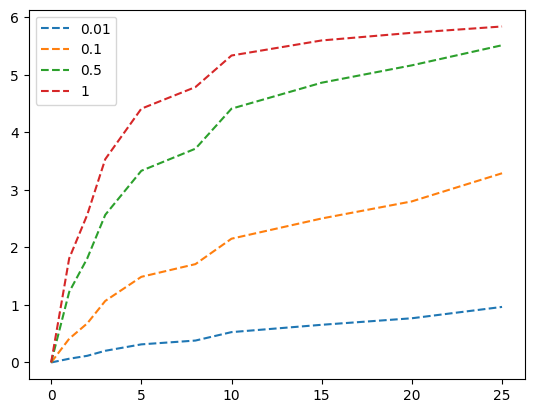

In [120]:
for lamda in lamdas:
    H_er_rw_lcc = compute_S_rate.compute_conditional_entropy(net=er_lcc_rw, list_T=er_lcc_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p0_er_lcc)
    plt.plot([0] + times[:-1], H_er_rw_lcc[list(H_er_rw_lcc.keys())[0]], '--', label = str(lamda))

plt.legend()
plt.show()

### Comparison  configuration model vs ER

In [121]:
colors = auxiliary_functions.generate_random_colors(len(lamdas))

In [140]:
# asymptot lcc
n_edges_lcc = lcc_adj.toarray().sum() / 2
degrees_lcc = lcc_adj.toarray().sum(0)

avg_degree_lcc = np.mean(degrees_lcc)

corrected_degrees_lcc  = np.where(degrees_lcc > 0, degrees_lcc, 1)
avg_degreelogdegree_lcc = np.mean(degrees_lcc * np.log(corrected_degrees_lcc))
asymptot_lcc = np.log(2 * n_edges_lcc) - avg_degreelogdegree_lcc / avg_degree_lcc

#asymptot er_lcc
n_edges_er_lcc = er_lcc_adj.toarray().sum() / 2
degrees_er_lcc = er_lcc_adj.toarray().sum(0)

avg_degree_er_lcc = np.mean(degrees_er_lcc)

corrected_degrees_er_lcc  = np.where(degrees_er_lcc > 0, degrees_er_lcc, 1)
avg_degreelogdegree_er_lcc = np.mean(degrees_er_lcc * np.log(corrected_degrees_er_lcc))
asymptot_er_lcc = np.log(2 * n_edges_er_lcc) - avg_degreelogdegree_er_lcc / avg_degree_er_lcc

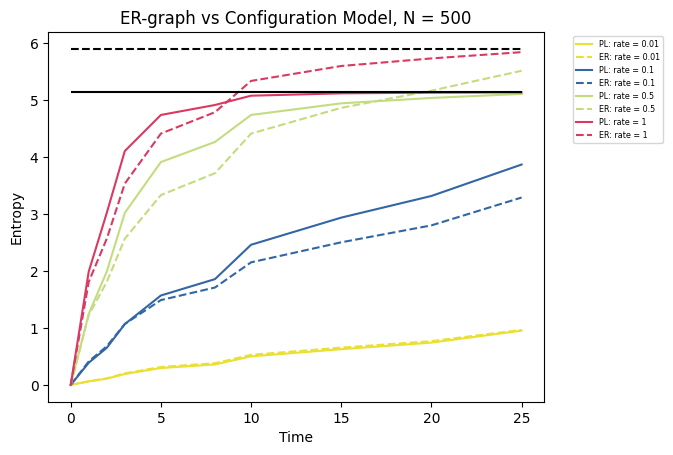

In [154]:
for i, lamda in enumerate(lamdas):
    H_lcc_rw = compute_S_rate.compute_conditional_entropy(net=lcc_rw, list_T=lcc_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p0)
    plt.plot([0] + times[:-1], H_lcc_rw[list(H_lcc_rw.keys())[0]], color=colors[i], label = 'PL: rate = ' + str(lamda))
    H_er_rw_lcc = compute_S_rate.compute_conditional_entropy(net=er_lcc_rw, list_T=er_lcc_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p0_er_lcc)
    plt.plot([0] + times[:-1], H_er_rw_lcc[list(H_er_rw_lcc.keys())[0]], '--', color=colors[i], label = 'ER: rate = ' + str(lamda))

#adding asymptots
plt.hlines(asymptot_lcc, 0, times[-2], 'black')
plt.hlines(asymptot_er_lcc, 0, times[-2], colors = 'black', linestyles='--')

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("ER-graph vs Configuration Model, N = 500")
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditionalH_PLvsER.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## Discrite-Time Approximation

In [149]:
excess_degree = (np.mean(np.square(degrees_lcc)) - mean_degree_lcc) / mean_degree_lcc

In [150]:
excess_degree

21.346907993966816

In [ ]:
times

In [152]:
sum_shells = 1 + avg_degree_lcc
list_model_entropies = [0]
shell = 1
while True:
    if shell <= times[-1] - 1:
        if sum_shells + sum_shells * excess_degree < N:
            sum_shells += sum_shells *excess_degree
            shell += 1

            H = min(asymptot_lcc, np.log(sum_shells))
            list_model_entropies.append(H)
        else:
            sum_shells = N
            list_model_entropies.append(asymptot_lcc)
            shell += 1
    else:
        break

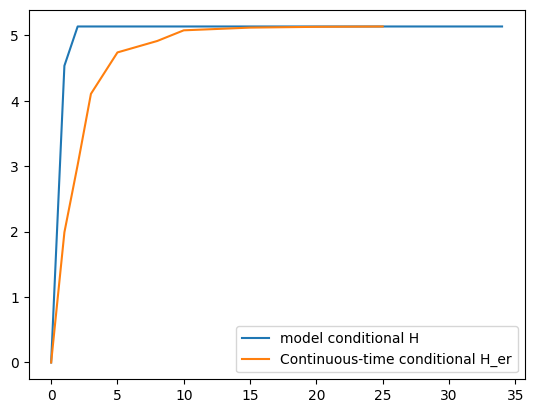

In [153]:
#plt.plot([0] + times, list_H_er, label = 'Discrete-time conditional H_er')
plt.plot(range(len(list_model_entropies)), list_model_entropies, label = 'model conditional H')
#plt.plot(range(len(list_model_entropies2)), list_model_entropies2, label = 'logistic model conditional H')

H_lcc_rw = compute_S_rate.compute_conditional_entropy(net=lcc_rw, list_T=lcc_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = p0)
plt.plot([0] + times[:-1], H_lcc_rw[list(H_lcc_rw.keys())[-1]], label = 'Continuous-time conditional H_er')
plt.legend()
plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditional_entropyER.png', format='png', dpi=300)
plt.show()